# 🚂 Train Delay Prediction Model Training (CSV Version)

This notebook trains a machine learning model to predict train delays using historical data from local CSV files.

## Steps:
1. Load and explore data from CSV
2. Feature engineering
3. Train model
4. Evaluate performance
5. Save model for deployment

In [110]:
# Install required packages
# !pip install pandas numpy scikit-learn xgboost matplotlib seaborn plotly joblib

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import joblib
import warnings
import ast

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Data Loading and Exploration (from CSV)

In [112]:
# Load local CSVs
departures = pd.read_csv('../data/raw/train_departures.csv')
stations = pd.read_csv('../data/raw/stations.csv')


df = departures.merge(
    stations, left_on='FromLocation', right_on='LocationSignature', how='left', suffixes=('', '_from')
).merge(
    stations, left_on='ToLocation', right_on='LocationSignature', how='left', suffixes=('', '_to')
)

def extract_location_name(location_str):
    """
    Extracts the LocationName from a string like:
    "[{'LocationName': 'Mr', 'Priority': 1, 'Order': 0}]"
    """
    try:
        # Convert string to Python object (list of dicts)
        locations = ast.literal_eval(location_str)
        if isinstance(locations, list) and len(locations) > 0:
            return locations[0].get('LocationName', None)
    except Exception:
        pass
    return None

df['from_station'] = df['FromLocation'].apply(extract_location_name)
df['to_station'] = df['ToLocation'].apply(extract_location_name)

print('InformationOwner:', df['InformationOwner'].replace('', pd.NA).dropna().shape[0])
print('Operator:', df['Operator'].replace('', pd.NA).dropna().shape[0])
print('TrainOwner:', df['TrainOwner'].replace('', pd.NA).dropna().shape[0])



df[df.select_dtypes(include=['number']).columns] = df.select_dtypes(include=['number']).fillna(0)

# Fill string/object columns with empty string
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).fillna('')



print(f'📊 Loaded {len(df):,} records')
print(f'📅 Data shape: {df.shape}')
df.head()


InformationOwner: 10000
Operator: 9999
TrainOwner: 9875
📊 Loaded 10,000 records
📅 Data shape: (10000, 58)


,ActivityId,ActivityType,Advertised,AdvertisedTimeAtLocation,AdvertisedTrainIdent,Canceled,Deleted,DepartureDateOTN,Deviation,EstimatedTimeIsPreliminary,...,CountryCode_to,CountyNo_to,Deleted_to,LocationSignature_to,Prognosticated_to,OfficialLocationName_to,Geometry.SWEREF99TM_to,Geometry.WGS84_to,from_station,to_station
0,1500adde-385d-31b6-08dd-903eab6b3e79,Avgang,True,2025-05-26 00:00:00+02:00,2983,False,False,2025-05-26T00:00:00.000+02:00,"[{'Code': 'ANA031', 'Description': 'Kort tåg'}]",False,...,,,,,,,,,Mr,Äs
1,1500adde-385d-31b6-08dd-903ec887c620,Avgang,True,2025-05-26 00:03:00+02:00,63591,False,False,0001-01-01T00:00:00.000+01:00,"[{'Code': 'ANA274', 'Description': 'Buss 22R'}...",False,...,,,,,,,,,Lr,G
2,1500adde-385d-31b6-08dd-903ec43fcb52,Avgang,True,2025-05-26 00:03:00+02:00,52277,False,False,2025-05-26T00:00:00.000+02:00,"[{'Code': 'ANA031', 'Description': 'Kort tåg'}]",False,...,,,,,,,,,Söc,Gn
3,1500adde-385d-31b6-08dd-903e4bd58ac3,Avgang,True,2025-05-26 00:04:00+02:00,1243,True,False,2025-05-26T00:00:00.000+02:00,"[{'Code': 'ANA007', 'Description': 'Buss ersät...",False,...,,,,,,,,,Cr,Hm
4,1500adde-385d-31b6-08dd-903eb9d748cf,Avgang,True,2025-05-26 00:04:00+02:00,3594,False,False,2025-05-26T00:00:00.000+02:00,,False,...,,,,,,,,,Lr,A


In [113]:
# Basic data exploration
print('📈 Dataset Info:')
print(df.info())
print('📊 Delay Statistics:')
print(df['DelayMinutes'].describe())



📈 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 58 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ActivityId                             10000 non-null  object 
 1   ActivityType                           10000 non-null  object 
 2   Advertised                             10000 non-null  bool   
 3   AdvertisedTimeAtLocation               10000 non-null  object 
 4   AdvertisedTrainIdent                   10000 non-null  int64  
 5   Canceled                               10000 non-null  bool   
 6   Deleted                                10000 non-null  bool   
 7   DepartureDateOTN                       10000 non-null  object 
 8   Deviation                              10000 non-null  object 
 9   EstimatedTimeIsPreliminary             10000 non-null  bool   
 10  FromLocation                           10000 non-null  

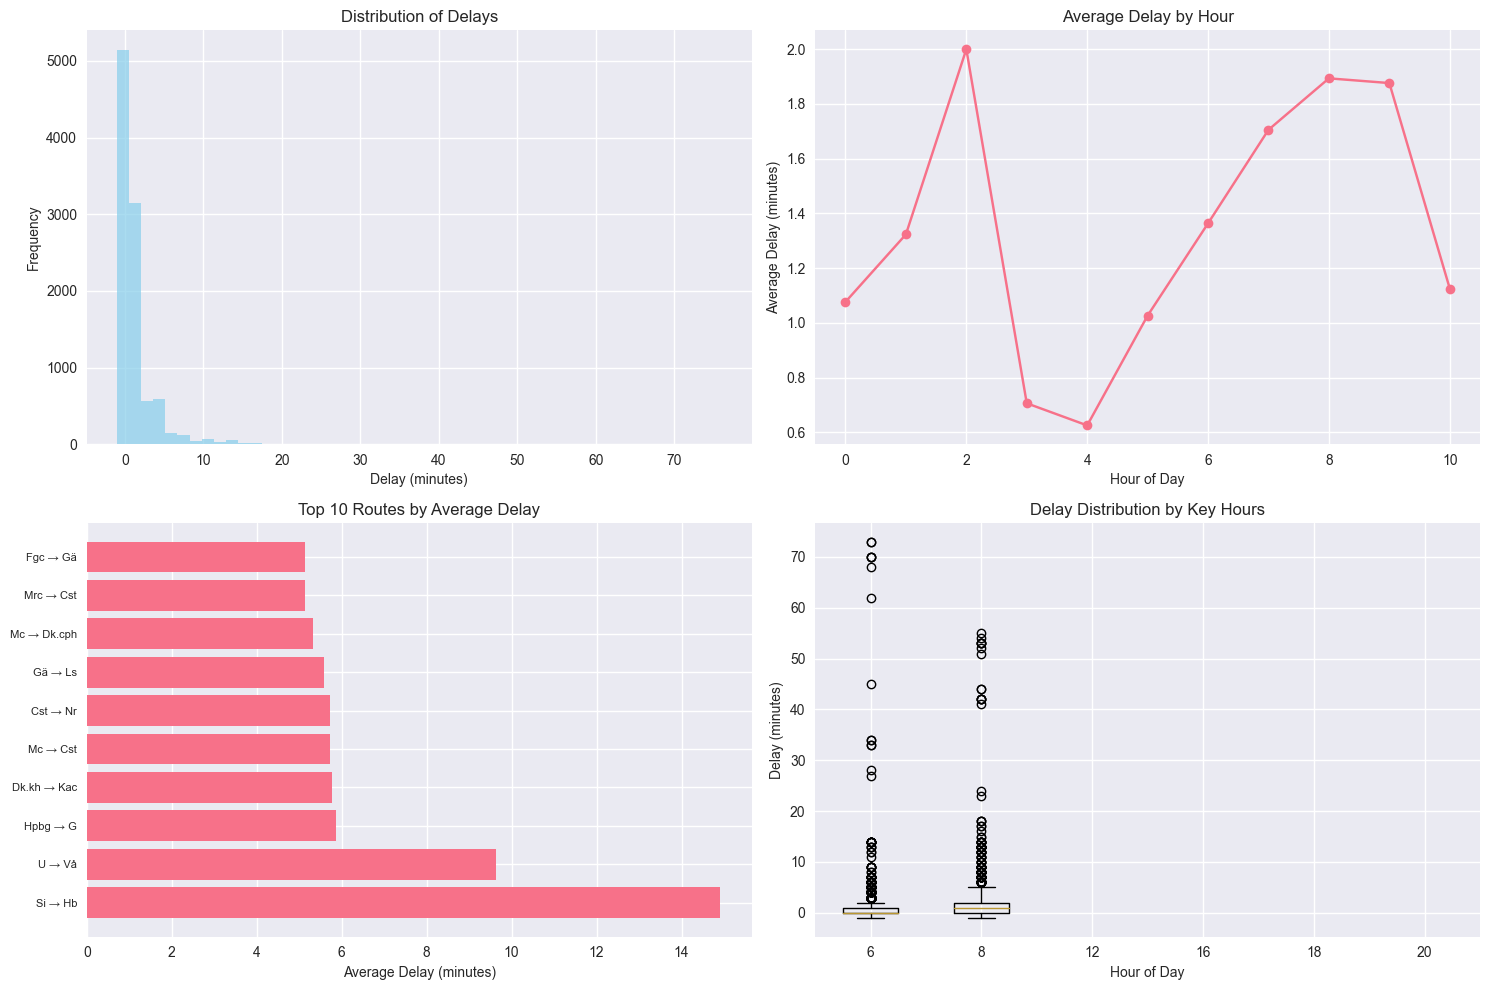

In [114]:
# Visualize delay distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Delay histogram
axes[0,0].hist(df['DelayMinutes'], bins=50, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribution of Delays')
axes[0,0].set_xlabel('Delay (minutes)')
axes[0,0].set_ylabel('Frequency')

# Delay by hour
hourly_delay = df.groupby('Hour')['DelayMinutes'].mean()
axes[0,1].plot(hourly_delay.index, hourly_delay.values, marker='o')
axes[0,1].set_title('Average Delay by Hour')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Average Delay (minutes)')
axes[0,1].grid(True)

# Top routes by delay
df['route'] = df['from_station'] + ' → ' + df['to_station']
top_routes = df.groupby('route')['DelayMinutes'].mean().sort_values(ascending=False).head(10)
axes[1,0].barh(range(len(top_routes)), top_routes.values)
axes[1,0].set_yticks(range(len(top_routes)))
axes[1,0].set_yticklabels(top_routes.index, fontsize=8)
axes[1,0].set_title('Top 10 Routes by Average Delay')
axes[1,0].set_xlabel('Average Delay (minutes)')

# Delay box plot by hour (simplified)
sample_hours = [6, 8, 12, 16, 18, 20]
delay_by_hour = [df[df['Hour'] == h]['DelayMinutes'].values for h in sample_hours]
axes[1,1].boxplot(delay_by_hour, labels=sample_hours)
axes[1,1].set_title('Delay Distribution by Key Hours')
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_ylabel('Delay (minutes)')

plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [115]:
def create_features(df):
    """Create features for training"""
    df = df.copy()
    
    # Route identifier
    df['route'] = df['from_station'] + '_' + df['to_station']
    
    # Time-based features (cyclical encoding)
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    
     
    
    # Peak hour indicators
    df['is_rush_hour'] = ((df['Hour'] >= 7) & (df['Hour'] <= 9)) | ((df['Hour'] >= 17) & (df['Hour'] <= 19))
    df['is_night'] = (df['Hour'] <= 6) | (df['Hour'] >= 22)
    
    return df

# Apply feature engineering
df_features = create_features(df)
print(f'✅ Created features. New shape: {df_features.shape}')
print(f'📋 Features: {list(df_features.columns)}')

✅ Created features. New shape: (10000, 63)
📋 Features: ['ActivityId', 'ActivityType', 'Advertised', 'AdvertisedTimeAtLocation', 'AdvertisedTrainIdent', 'Canceled', 'Deleted', 'DepartureDateOTN', 'Deviation', 'EstimatedTimeIsPreliminary', 'FromLocation', 'InformationOwner', 'LocationDateTimeOTN', 'LocationSignature', 'ModifiedTime', 'NewEquipment', 'Operator', 'OperationalTrainNumber', 'PlannedEstimatedTimeAtLocationIsValid', 'ScheduledDepartureDateTime', 'TimeAtLocation', 'ToLocation', 'TrackAtLocation', 'TrainOwner', 'Booking', 'EstimatedTimeAtLocation', 'Service', 'TrainComposition', 'PlannedEstimatedTimeAtLocation', 'ViaFromLocation', 'Hour', 'DelayMinutes', 'Advertised_from', 'AdvertisedLocationName', 'AdvertisedShortLocationName', 'PrimaryLocationCode', 'CountryCode', 'CountyNo', 'Deleted_from', 'LocationSignature_from', 'Prognosticated', 'OfficialLocationName', 'Geometry.SWEREF99TM', 'Geometry.WGS84', 'Advertised_to', 'AdvertisedLocationName_to', 'AdvertisedShortLocationName_to',

In [116]:
# Prepare features for training
feature_columns = [
    'Hour', 'hour_sin', 'hour_cos',  
    'is_rush_hour', 'is_night', 'route', 'InformationOwner'
]


# Create feature matrix
X = df_features[feature_columns].copy()
y = df_features['DelayMinutes']


# Encode categorical variables
label_encoders = {}
categorical_columns = ['route', 'InformationOwner']

for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[f'{col}_encoder'] = le

print(f'🎯 Target variable (delay) - Mean: {y.mean():.2f}, Std: {y.std():.2f}')
print(f'📊 Feature matrix shape: {X.shape}')

🎯 Target variable (delay) - Mean: 1.57, Std: 4.37
📊 Feature matrix shape: (10000, 7)


## 4. Model Training

In [117]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'📊 Training set: {X_train.shape[0]:,} samples')
print(f'📊 Test set: {X_test.shape[0]:,} samples')

📊 Training set: 8,000 samples
📊 Test set: 2,000 samples


In [118]:
# Train XGBoost model
print('🚀 Training XGBoost model...')

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
print('✅ XGBoost training completed')

🚀 Training XGBoost model...
✅ XGBoost training completed


In [119]:
# Train Random Forest for comparison
print('🌲 Training Random Forest model...')

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print('✅ Random Forest training completed')

🌲 Training Random Forest model...
✅ Random Forest training completed


## 5. Model Evaluation

In [120]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance"""
    y_pred = model.predict(X_test)
    
    # Ensure no negative predictions
    y_pred = np.maximum(y_pred, 0)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f'📊 {model_name} Performance:')
    print(f'   RMSE: {rmse:.2f} minutes')
    print(f'   MAE:  {mae:.2f} minutes')
    print(f'   R²:   {r2:.3f}')
    
    return {
        'predictions': y_pred,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# Evaluate both models
xgb_results = evaluate_model(xgb_model, X_test, y_test, 'XGBoost')
rf_results = evaluate_model(rf_model, X_test, y_test, 'Random Forest')

📊 XGBoost Performance:
   RMSE: 3.94 minutes
   MAE:  1.63 minutes
   R²:   0.285
📊 Random Forest Performance:
   RMSE: 3.94 minutes
   MAE:  1.61 minutes
   R²:   0.284


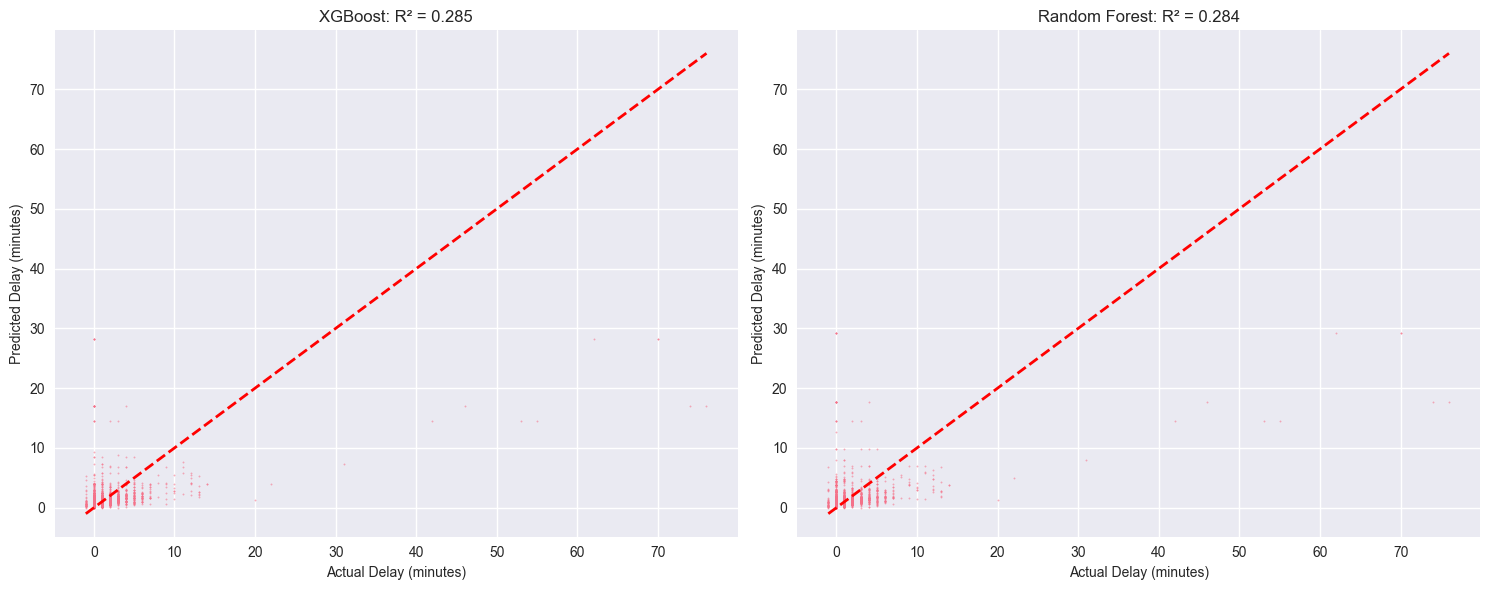

In [121]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# XGBoost
axes[0].scatter(y_test, xgb_results['predictions'], alpha=0.5, s=1)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Delay (minutes)')
axes[0].set_ylabel('Predicted Delay (minutes)')
axes[0].set_title(f'XGBoost: R² = {xgb_results["r2"]:.3f}')
axes[0].grid(True)

# Random Forest
axes[1].scatter(y_test, rf_results['predictions'], alpha=0.5, s=1)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Delay (minutes)')
axes[1].set_ylabel('Predicted Delay (minutes)')
axes[1].set_title(f'Random Forest: R² = {rf_results["r2"]:.3f}')
axes[1].grid(True)

plt.tight_layout()
plt.show()

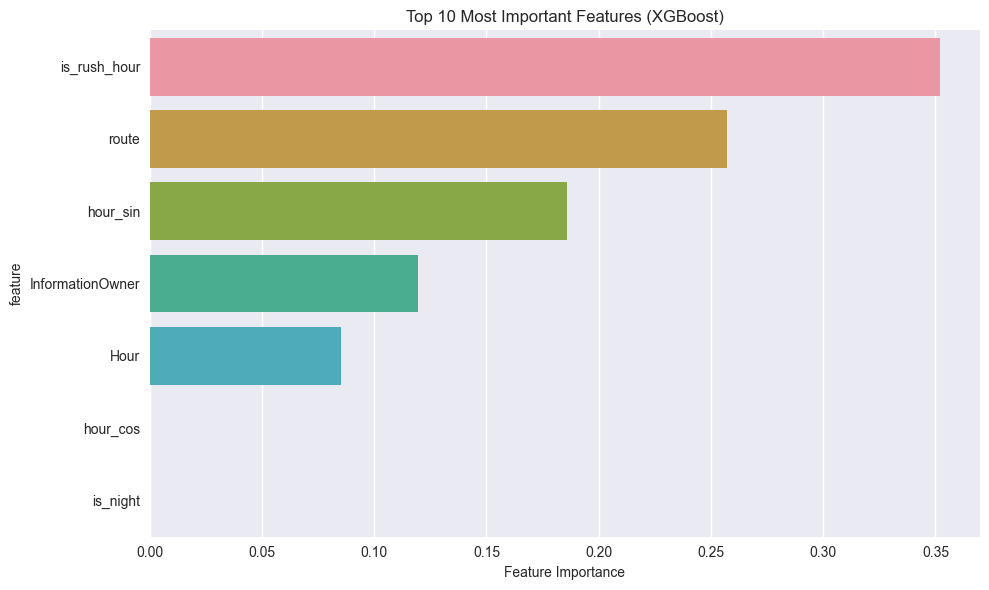

🔍 Top 5 Most Important Features:
   is_rush_hour: 0.352
   route: 0.257
   hour_sin: 0.186
   InformationOwner: 0.120
   Hour: 0.085


In [122]:
# Feature importance
feature_names = X.columns

# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features (XGBoost)')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print('🔍 Top 5 Most Important Features:')
for i, row in xgb_importance.head().iterrows():
    print(f"   {row['feature']}: {row['importance']:.3f}")

## 6. Model Selection and Saving

In [123]:
# Select best model based on RMSE
if xgb_results['rmse'] < rf_results['rmse']:
    best_model = xgb_model
    best_model_name = 'XGBoost'
    best_results = xgb_results
else:
    best_model = rf_model
    best_model_name = 'Random Forest'
    best_results = rf_results

print(f"🏆 Best Model: {best_model_name}")
print(f"   RMSE: {best_results['rmse']:.2f} minutes")
print(f"   MAE:  {best_results['mae']:.2f} minutes")
print(f"   R²:   {best_results['r2']:.3f}")

🏆 Best Model: XGBoost
   RMSE: 3.94 minutes
   MAE:  1.63 minutes
   R²:   0.285


In [125]:
# Save the trained model and encoders
print('💾 Saving model and encoders...')

# Save the best model
joblib.dump(best_model, '../streamlit/trained_model.pkl')
print(f"✅ Saved {best_model_name} model to 'trained_model.pkl'")

# Save encoders
joblib.dump(label_encoders, '../streamlit/encoders.pkl')
print("✅ Saved encoders to 'encoders.pkl'")

# Save feature names for reference
feature_info = {
    'feature_names': list(feature_names),
    'model_type': best_model_name,
    'performance': {
        'rmse': best_results['rmse'],
        'mae': best_results['mae'],
        'r2': best_results['r2']
    }
}

import json
# Get unique values
info_owner_options = sorted(df_features['InformationOwner'].dropna().unique())
from_station_options = sorted(df_features['from_station'].dropna().unique())
to_station_options = sorted(df_features['to_station'].dropna().unique())

# Save to JSON files in the streamlit directory
with open('../streamlit/info_owner_options.json', 'w') as f:
    json.dump(info_owner_options, f)
with open('../streamlit/from_station_options.json', 'w') as f:
    json.dump(from_station_options, f)
with open('../streamlit/to_station_options.json', 'w') as f:
    json.dump(to_station_options, f)




with open('../streamlit/model_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)
print("✅ Saved model info to 'model_info.json'")

💾 Saving model and encoders...
✅ Saved XGBoost model to 'trained_model.pkl'
✅ Saved encoders to 'encoders.pkl'
✅ Saved model info to 'model_info.json'


## 7. Model Testing with Sample Predictions

In [129]:
# Test the model with some sample predictions
def make_sample_prediction(from_station, to_station, hour):
    # Get station info from our data
    sample_route = df_features[
        (df_features['from_station'] == from_station) & 
        (df_features['to_station'] == to_station)
    ]
    
    if sample_route.empty:
        print(f'❌ No data found for route {from_station} → {to_station}')
        return None
    
    # Use first available record for coordinates and route stats
    route_data = sample_route.iloc[0]
    
    # Create prediction features
    pred_features = {
        'Hour': hour,
        'hour_sin': np.sin(2 * np.pi * hour / 24),
        'hour_cos': np.cos(2 * np.pi * hour / 24),
        'is_rush_hour': (7 <= hour <= 9) or (17 <= hour <= 19),
        'is_night': (hour <= 6) or (hour >= 22),
        'InformationOwner': label_encoders['InformationOwner_encoder'].transform([route_data['InformationOwner']])[0],
        'route': label_encoders['route_encoder'].transform([route_data['route']])[0]
    }
    
    # Create feature array
    X_pred = np.array([[pred_features[col] for col in feature_names]])
    
    # Make prediction
    prediction = best_model.predict(X_pred)[0]
    prediction = max(0, prediction)  # No negative delays
    
    return prediction

# Test with sample routes
print('🧪 Testing model with sample predictions:\n')

# Get some sample routes from our data
sample_routes = df_features[['from_station', 'to_station']].drop_duplicates().head(5)

for _, route in sample_routes.iterrows():
    from_st = route['from_station']
    to_st = route['to_station']
    
    # Test different hours
    for test_hour in [8, 14, 18]:  # Morning rush, afternoon, evening rush
        pred = make_sample_prediction(from_st, to_st, test_hour)
        if pred is not None:
            print(f'🚂 {from_st} → {to_st} at {test_hour:02d}:00 → Predicted delay: {pred:.1f} minutes')
    print()

🧪 Testing model with sample predictions:

🚂 Mr → Äs at 08:00 → Predicted delay: 0.9 minutes
🚂 Mr → Äs at 14:00 → Predicted delay: 0.5 minutes
🚂 Mr → Äs at 18:00 → Predicted delay: 0.2 minutes

🚂 Lr → G at 08:00 → Predicted delay: 0.5 minutes
🚂 Lr → G at 14:00 → Predicted delay: 0.3 minutes
🚂 Lr → G at 18:00 → Predicted delay: 0.4 minutes

🚂 Söc → Gn at 08:00 → Predicted delay: 1.0 minutes
🚂 Söc → Gn at 14:00 → Predicted delay: 0.6 minutes
🚂 Söc → Gn at 18:00 → Predicted delay: 1.1 minutes

🚂 Cr → Hm at 08:00 → Predicted delay: 0.2 minutes
🚂 Cr → Hm at 14:00 → Predicted delay: 0.4 minutes
🚂 Cr → Hm at 18:00 → Predicted delay: 0.5 minutes

🚂 Lr → A at 08:00 → Predicted delay: 0.5 minutes
🚂 Lr → A at 14:00 → Predicted delay: 0.3 minutes
🚂 Lr → A at 18:00 → Predicted delay: 0.4 minutes



## 8. Summary and Next Steps

In [130]:
print('\n' + '='*60)
print('🎉 MODEL TRAINING COMPLETE!')
print('='*60)
print(f"📊 Best Model: {best_model_name}")
print(f"📈 Performance: RMSE = {best_results['rmse']:.2f} min, R² = {best_results['r2']:.3f}")
print(f'📁 Files created:')
print(f'   • trained_model.pkl (main model)')
print(f'   • encoders.pkl (label encoders)')
print(f'   • model_info.json (metadata)')
print('\n🚀 Next Steps:')
print('   1. Run the Streamlit app: streamlit run app.py')
print('   2. Test predictions with your own data')
print('   3. Deploy to Streamlit Cloud via GitHub')
print('   4. Share with users!')
print('='*60)


🎉 MODEL TRAINING COMPLETE!
📊 Best Model: XGBoost
📈 Performance: RMSE = 3.94 min, R² = 0.285
📁 Files created:
   • trained_model.pkl (main model)
   • encoders.pkl (label encoders)
   • model_info.json (metadata)

🚀 Next Steps:
   1. Run the Streamlit app: streamlit run app.py
   2. Test predictions with your own data
   3. Deploy to Streamlit Cloud via GitHub
   4. Share with users!
